In [23]:
import numpy as np 
import glob 
import vtk
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from AngioMorphPCA.preprocessing import parameterize_curve
from AngioMorphPCA.io import Get_simple_vtk
from scipy.integrate import simps
from AngioMorphPCA.GenerateDiffHemeo import generate_diff_homeomorphism
from AngioMorphPCA.srvf_rep import compute_srvf_func, reconstruct_curve_from_srvf
from AngioMorphPCA.L2distance import calculate_l2_distance
from procrustes import rotational
from tqdm import tqdm

# all_L2_table = np.load("../all_L2_table.npy")
# print (all_L2_table.shape)
# interpolation_nums = np.array([50, 100, 200, 400, 800, 1600])
# fig = plt.figure(dpi=100)
# ax = fig.add_subplot(111)
# ax.plot(1/interpolation_nums, np.mean(all_L2_table, axis=1), marker='o', color='b')
# ax.scatter(1/interpolation_nums, np.min(all_L2_table, axis=1), marker='v', color='r')
# ax.scatter(1/interpolation_nums, np.max(all_L2_table, axis=1), marker='^', color='g')
# ax.set_xticks(1/interpolation_nums)
# ax.set_xticklabels(interpolation_nums, rotation=60)
# for i in range(len(interpolation_nums)):
#     # ax.axvline(x=1/i,  linestyle='--', alpha=0.5, color='blue')
#     ax.annotate(str(interpolation_nums[i]), (1/interpolation_nums[i], np.mean(all_L2_table, axis=1)[i]))
# # plt.savefig("L2_distance_mean.png")
# # plt.close()
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlabel("Curve Resolution")
# ax.set_ylabel("L2 Distance")
# plt.grid()
# plt.show()
def makeVtkFile(savePath, coords, scalarAttributes):
    v = open(savePath, "w+")
    v.write("# vtk DataFile Version 2.0\nVessel Segment\nASCII\nDATASET POLYDATA\nPOINTS {} float\n".format(len(coords)))
    for i in range(len(coords)):
        v.write("{} {} {}\n".format(coords[i,0], coords[i,1], coords[i,2]))

    v.write("LINES {} {}\n".format(1, len(coords)+1))
    v.write("{}".format(len(coords)))
    for i in range(len(coords)):
        v.write(" {}".format(i))
    v.write("\n")

    ####################################
    #        scalar Attributes         #
    ####################################

    if len(scalarAttributes) > 0:
        v.write("POINT_DATA {}\n".format(len(coords)))
        for i in range(len(scalarAttributes)):
            v.write("SCALARS {} {}\n".format(scalarAttributes[i][0], scalarAttributes[i][1]))
            v.write("LOOKUP_TABLE default\n")
            for j in range(len(coords)):
                    v.write("{}\n".format(scalarAttributes[i][2][j]))

    v.close()

(82, 100, 3)


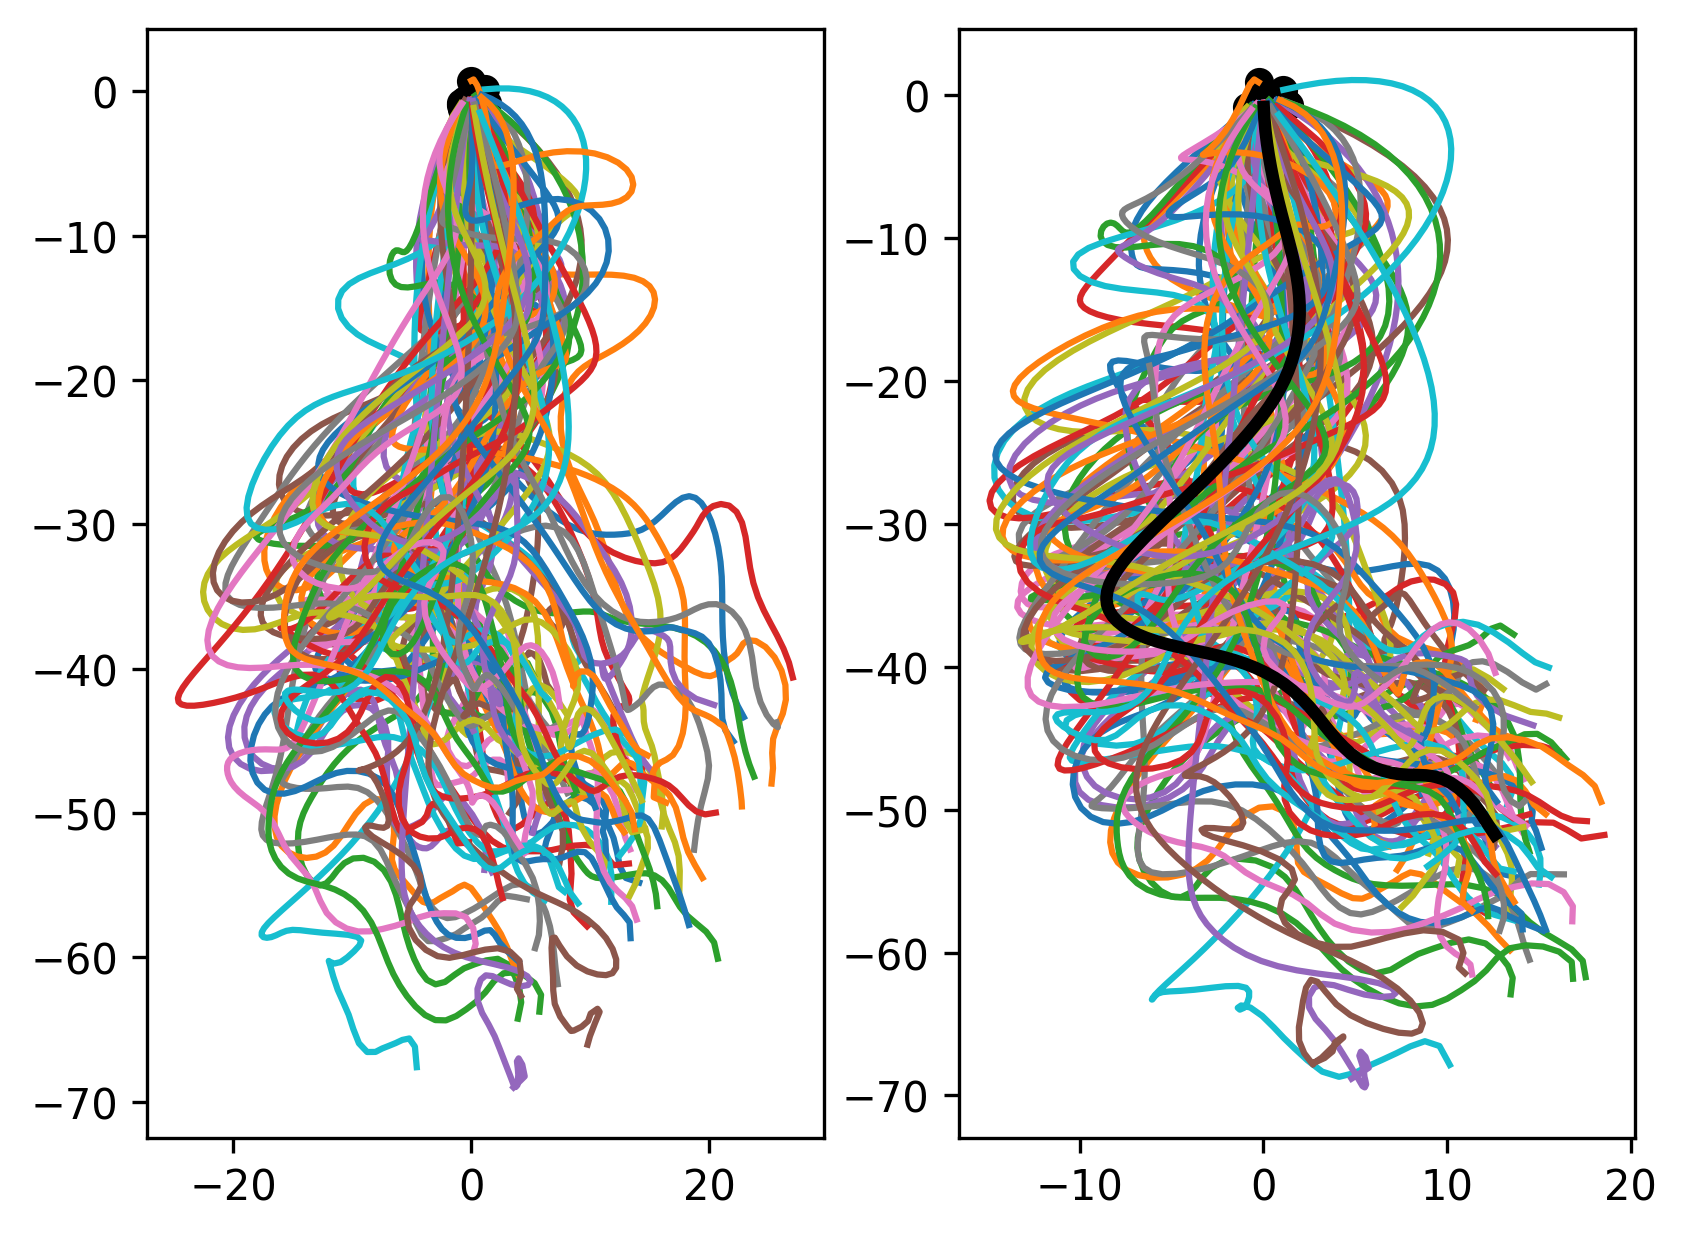

In [24]:
min_reparam = np.load("../save_orbits/24-04-02-11-41-14/min_reparam.npy")

from procrustes import generalized

min_reparamm, _ = generalized(min_reparam)

print (min_reparam.shape)
fig = plt.figure(dpi=300)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
reconstructed_curve = []
for i in range(len(min_reparam)):
    r_curve = reconstruct_curve_from_srvf(min_reparam[i],np.array([0,0,0]))
    reconstructed_curve.append(r_curve)
    ax1.plot(r_curve[:,2], r_curve[:,1])
    ax1.scatter(r_curve[0,2], r_curve[0,1], color='k')


reconstructed_curve, _ = generalized(reconstructed_curve)
for i in range(len(min_reparam)):
    ax2.plot(reconstructed_curve[i][:,2], reconstructed_curve[i][:,1])
    ax2.scatter(reconstructed_curve[i][0,2], reconstructed_curve[i][0,1], color='k')

    makeVtkFile("../save_orbits/24-04-02-11-41-14/{}.vtk".format(i), reconstructed_curve[i], [])



average_curve = np.mean(reconstructed_curve, axis=0)
ax2.plot(average_curve[:,2], average_curve[:,1], color='black', linewidth=3)
reconstructed_curve = np.array(reconstructed_curve)

makeVtkFile("../save_orbits/24-04-02-11-41-14/reconstructed_average_curve.vtk", average_curve, [])

C:\Users\cheno\AppData\Local\Temp\ipykernel_19804\1206170481.py:24: RuntimeWarning: invalid value encountered in divide
  curvature = np.where(r_prime_norm**3 > epsilon, cross_norm / (r_prime_norm ** 3), 0)
C:\Users\cheno\AppData\Local\Temp\ipykernel_19804\1206170481.py:27: RuntimeWarning: invalid value encountered in divide
  torsion = np.where(cross_norm**2 > epsilon, torsion_numerator / (cross_norm ** 2), 0)


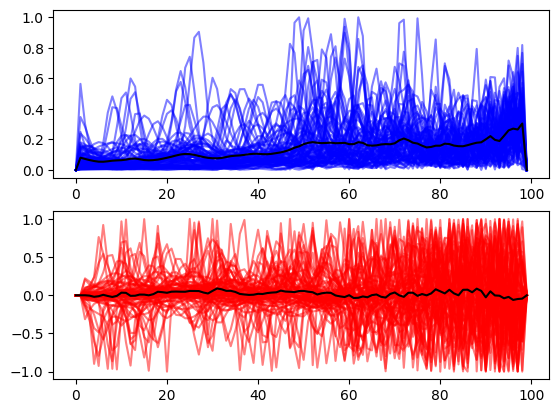

In [25]:
def compute_curvature_and_torsion(curve):

    # calculate first, second, and third derivatives using finite differences
    r_prime = np.diff(curve, axis=0)
    r_double_prime = np.diff(r_prime, axis=0)
    r_triple_prime = np.diff(r_double_prime, axis=0)

    # Pad derivatives to align array sizes
    r_prime = np.vstack((r_prime, np.zeros((1, 3))))
    r_double_prime = np.vstack((np.zeros((1, 3)), r_double_prime, np.zeros((1, 3))))
    r_triple_prime = np.vstack((np.zeros((2, 3)), r_triple_prime, np.zeros((2, 3))))

    # Ensure that r_prime, r_double_prime, and r_triple_prime have the same shape
    min_length = min(len(r_prime), len(r_double_prime), len(r_triple_prime))
    r_prime = r_prime[:min_length]
    r_double_prime = r_double_prime[:min_length]
    r_triple_prime = r_triple_prime[:min_length]

    cross_product = np.cross(r_prime, r_double_prime)
    cross_norm = np.linalg.norm(cross_product, axis=1)
    r_prime_norm = np.linalg.norm(r_prime, axis=1)

    epsilon = 1e-7
    curvature = np.where(r_prime_norm**3 > epsilon, cross_norm / (r_prime_norm ** 3), 0)

    torsion_numerator = np.einsum('ij,ij->i', r_prime, np.cross(r_double_prime, r_triple_prime))
    torsion = np.where(cross_norm**2 > epsilon, torsion_numerator / (cross_norm ** 2), 0)

    # Apply non-linear transformation
    curvature = np.tanh(curvature)
    torsion = np.tanh(torsion)


    # Create the interpolator functions for curvature and torsion
    # We are using 'linear' interpolation and 'extrapolate' to allow extension beyond the original range
    interp_curvature = interp1d(np.arange(len(curvature)), curvature, kind='linear', fill_value="extrapolate")
    interp_torsion = interp1d(np.arange(len(torsion)), torsion, kind='linear', fill_value="extrapolate")

    # Use the interpolator functions to extend the arrays to the original curve length
    interpolated_curvature = interp_curvature(np.arange(len(curve)))
    interpolated_torsion = interp_torsion(np.arange(len(curve)))

    return interpolated_curvature, interpolated_torsion

curvatures = []
torsions = []
fig = plt.figure(dpi=100)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
for i in range(len(reconstructed_curve)):
    curvature,torsion = compute_curvature_and_torsion(reconstructed_curve[i])
    curvatures.append(curvature)
    torsions.append(torsion)
    ax1.plot(curvature, label='curvature', color='blue', alpha=0.5)
    ax2.plot(torsion, label='torsion', color='red', alpha=0.5)
# plt.legend()
ax1.plot(np.mean(curvatures, axis=0), label='curvature', color='black', alpha=1)
ax2.plot(np.mean(torsions, axis=0), label='torsion', color='black', alpha=1)
plt.show()
    

In [26]:
from sklearn.decomposition import PCA

flatten = min_reparam.reshape(min_reparam.shape[0],-1)
pca = PCA(n_components=2)
pca.fit(std_min_reparam)
print (pca.explained_variance_ratio_)

ValueError: Expected 2D array, got 1D array instead:
array=[0.35424242 0.26220511 0.44349952 0.30878967 0.21117093 0.40833895
 0.26958964 0.17299213 0.38001291 0.24013104 0.15425059 0.35694898
 0.22013233 0.14594751 0.33740352 0.2067219  0.14233877 0.32004017
 0.1972924  0.14105872 0.30394431 0.19019611 0.14179398 0.28850033
 0.18510884 0.14603037 0.27361145 0.18221019 0.15629315 0.26033714
 0.18041881 0.17274483 0.25047363 0.17879242 0.19132401 0.24465707
 0.17788558 0.2092442  0.24286782 0.17867409 0.22627928 0.2455462
 0.181852   0.24190294 0.25401554 0.18636384 0.25400199 0.26886472
 0.19066832 0.26072024 0.28737607 0.1942299  0.26180184 0.30616
 0.19713183 0.25814735 0.3233842  0.19961167 0.25143649 0.33844273
 0.20192196 0.24381973 0.35131557 0.20460407 0.23782236 0.36206048
 0.20869109 0.23571752 0.37081899 0.21552807 0.23852016 0.37883727
 0.22531877 0.2442386  0.39043247 0.2352267  0.24991118 0.40907103
 0.24330396 0.25558149 0.43108671 0.25005751 0.260851   0.45062468
 0.25640949 0.26358944 0.46428962 0.26263527 0.26161786 0.47115459
 0.26806798 0.25432582 0.47130714 0.27334949 0.24258067 0.46463567
 0.2796707  0.22715116 0.45095022 0.28623782 0.20858002 0.43008197
 0.29188691 0.18996637 0.40059386 0.2961197  0.17519231 0.36230495
 0.29801856 0.16663313 0.31802156 0.29464473 0.1653065  0.27372928
 0.28546476 0.16985096 0.23611828 0.27427104 0.17719463 0.21224851
 0.26579387 0.18511693 0.20768465 0.26182209 0.19273454 0.22262286
 0.26029154 0.2001862  0.25161551 0.25791338 0.20723429 0.28878806
 0.25336464 0.2132848  0.33102496 0.24814561 0.21873693 0.37584202
 0.24575002 0.2252575  0.41962492 0.24941923 0.23398275 0.4601365
 0.25960205 0.2466735  0.49713303 0.27499983 0.26729948 0.52977199
 0.29730823 0.29871546 0.5548493  0.31214827 0.33226398 0.57488151
 0.32248627 0.36236818 0.59036827 0.33353862 0.3838173  0.60215608
 0.34497854 0.39545735 0.60885744 0.35762129 0.40024878 0.60895526
 0.37547188 0.40177554 0.59935367 0.39805794 0.40399711 0.57785312
 0.42150436 0.40864826 0.54531512 0.44130565 0.41546746 0.50136096
 0.45017866 0.4266902  0.44621881 0.45150249 0.43682791 0.39281513
 0.44851228 0.44012611 0.3459406  0.44315605 0.43701954 0.30214342
 0.44249596 0.43535218 0.2752087  0.44780614 0.44359688 0.26259853
 0.44989672 0.46232406 0.25066552 0.44486797 0.48777237 0.24248874
 0.43631699 0.50676404 0.25118476 0.42542469 0.51248748 0.28199147
 0.41134776 0.50474311 0.31757043 0.39729097 0.4811173  0.33932512
 0.3867654  0.44405262 0.34502699 0.38742375 0.399772   0.35445913
 0.39612982 0.36558793 0.36065843 0.39843447 0.35673021 0.35688192
 0.39486455 0.36078057 0.35154308 0.39694202 0.36807747 0.35085688
 0.39546937 0.37638547 0.34540043 0.38062622 0.38805975 0.33089826
 0.35280677 0.40000201 0.32215799 0.32657409 0.40505856 0.31654682
 0.30049161 0.4073932  0.30224287 0.26949386 0.42204989 0.28909913
 0.25139756 0.4365888  0.26747131 0.25394294 0.4298813  0.25808871
 0.27858417 0.4038133  0.26958542 0.31537141 0.37771625 0.28238728
 0.32155848 0.36829506 0.29615072 0.3236783  0.38642381 0.30953779
 0.34183365 0.42028263 0.31370713 0.36459764 0.44888855 0.3127109
 0.40393075 0.48150273 0.30867448 0.44795747 0.50765785 0.30586445
 0.46565027 0.48958057 0.30072944 0.44784425 0.43116335 0.28574442
 0.40712633 0.36987385 0.2794702  0.36735025 0.29355158 0.30928925
 0.35519536 0.22520193 0.3452631  0.47851245 0.35783088 0.45148153].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [19]:
print (min_reparam.reshape(min_reparam.shape[0],-1).shape)

print (len(min_reparam))

(82, 300)
82
